# Evaluation of a single DAG

In [105]:
from bnm import BNMetrics, generate_random_dag, analyse_mb
import plotly.io as pio
pio.renderers.default = 'jupyterlab' #jupyterlab #jpeg

## Setup

Let’s assume we have a Directed Acyclic Graph (DAG), either produced by a causal discovery algorithm or constructed based on expert knowledge. This DAG represents a system of interest, where the edges indicate potential causal relationships.

Such systems may include:
- Interactions among metagenomic features in microbiome studies,  
- Interactions between micro and macroeconomic indicators, or
- Behavioral patterns of users interacting with an application.

To illustrate, let’s simulate a system comprising 400 attributes. In this notebook attributes, nodes and variables are used interchangeably.

In [47]:
dag = generate_random_dag(n_nodes=1000, edge_prob=0.005, seed=55)

The following three features of the `bnm` package are designed to support systematic exploration and understanding of complex systems:

## Feature 1
### Plot Markov Blankets of a Single Node or a List of Nodes of Interest 

When analyzing a complex system represented by a DAG, visual inspection can become challenging due to the large number of nodes and edges. To address this, it is helpful to focus on the **Markov blankets** of specific nodes of interest.

A **Markov blanket** is the minimal set of nodes that renders a given node conditionally independent from the rest of the network. It consists of:
- the node’s parents,  
- the node’s children, and  
- the other parents of its children.

Markov blanket is a powerful concept because it fully captures the local dependencies that explain the behavior of the target node.

The `bnm` package is particularly useful for such localized analysis. It provides functionality for visualizing:
- the Markov blanket of a single node, or  
- the Markov blankets of a specified list of nodes.

To begin, we instantiate a `BNMetrics` object. Once initialized, we can generate plots to visualize the Markov blankets of either a single node or multiple nodes of interest.


In [51]:
bnm_obj = BNMetrics(dag)

Let’s say we are interested in the variable `X_32`. For instance, we may be designing an intervention aimed at influencing the behavior of `X_32`.

In [94]:
bnm_obj.plot_bn(nodes=['X_32'], title='Makrov blanket of node X_32')

From the DAG above, we observe that the variable `X_32` receives a direct causal influence from the node `X_978`. Additionally, `X_32` has one child, `X_514`, and this child has four other parents.

If our goal is to influence `X_32`,, it would be reasonable to consider intervening on `X_978`, which directly affects `X_32`.

Suppose we find this information useful and want to explore further. We can visualize the Markov blankets of both `X_978` and `X_32` together to better understand the surrounding causal structure and identify potential pathways for intervention.


In [64]:
bnm_obj.plot_bn(nodes=['X_32', 'X_978'], title='Makrov blankets of nodes X_32 and X_978')

From the plot above, we can observe the structure of the Markov blankets for nodes `X_32` and `X_978`. Based on this structure, one possible strategy could be to intervene on `X_540`. Such an intervention might influence `X_978`, which in turn could affect our variable of interest, `X_32`.

To further explore the upstream influences, we may also want to include the parent(s) of `X_978` in our visualization. This helps to drill down into the causal pathways and identify additional leverage points for intervention.

In [65]:
bnm_obj.plot_bn(nodes=['X_32', 'X_978', 'X_540'], title='Makrov blankets of nodes X_32, X_514 and X_540')

Add parents of X_540

In [93]:
bnm_obj.plot_bn(nodes=['X_32', 'X_978', 'X_540', 'X_454'], title='Makrov blankets of nodes X_32, X_514, X_540 and X454')

Above, we can see the complete causal path from the root node `X_454` to the target node `X_32`. This level of detail would be difficult to observe if we were visualizing the entire DAG—at least in jupyter notebooks

## Feature 2
### Comprehensive Set of Descriptive Metrics

To gain a deeper understanding of the system of interest, we may want a comprehensive set of descriptive metrics. The `compare_df` method computes both descriptive and comparative metrics; however, since we are working with a single DAG, only the descriptive metrics are applicable here.

These metrics are reported for both the full DAG structure and the local structures (i.e., Markov blankets) of individual nodes. When the `node_name` column has the value `All`, it refers to the metrics computed for the entire DAG. Otherwise, `node_name` indicates the specific node whose Markov blanket is being analyzed.


In [71]:
descriptive_metrics_df = bnm_obj.compare_df(descriptive_metrics='All', comparison_metrics=None)

In [73]:
descriptive_metrics_df[:5]

,node_name,n_edges,n_nodes,n_colliders,n_root_nodes,n_leaf_nodes,n_isolated_nodes,n_directed_arcs,n_undirected_arcs,n_reversible_arcs,n_in_degree,n_out_degree
0,All,2497.0,1000.0,4100.0,202.0,188.0,9.0,2497.0,0.0,181.0,NaN,NaN
1,X_557,13.0,14.0,38.0,12.0,1.0,0.0,13.0,0.0,0.0,5.0,1.0
2,X_436,28.0,28.0,55.0,20.0,6.0,0.0,28.0,0.0,2.0,2.0,6.0
3,X_803,9.0,10.0,9.0,7.0,2.0,0.0,9.0,0.0,0.0,3.0,2.0
4,X_343,14.0,15.0,58.0,13.0,1.0,0.0,14.0,0.0,0.0,3.0,1.0


From the table above, we can see that the DAG contains 1,000 nodes and 2,497 edges. It also includes 4,100 colliders. Many causal discovery algorithms can orient edges only within collider or Y-structures, so the number of colliders serves as an indicator of how many potential causal relationships may be found in the network.

Other descriptive metrics are also valuable. For instance, `n_isolated` reveals the number of isolated nodes—those not connected to any other node. These isolated nodes may represent uninformative variables or areas where data does not support causal connections. Let’s take a closer look at them.


In [76]:
descriptive_metrics_df.query("n_isolated_nodes > 0 & node_name != 'All'").node_name.unique()

array(['X_850', 'X_44', 'X_91', 'X_364', 'X_818', 'X_536', 'X_784',
       'X_931', 'X_751'], dtype=object)

The nodes listed above are identified as isolated. Let’s confirm this visually with a plot.

In [77]:
bnm_obj.plot_bn(nodes=['X_850', 'X_44', 'X_91', 'X_364', 'X_818', 'X_536', 'X_784',
       'X_931', 'X_751'], title='Makrov blankets of isolated nodes')

The plot above confirms that these nodes are indeed isolated.

In addition to identifying isolated nodes, we may also want to gain further insights into the structure—such as pinpointing the most complex Markov blankets. In this context, complexity is represented by the `n_edges` metric, which indicates how many edges are involved in a node's local structure.


In [80]:
descriptive_metrics_df.query("node_name != 'All'").n_edges.max()

60.0

In our synthetic example, the most complex Markov blanket contains 60 edges. Let’s visualize it to better understand its structure.


In [89]:
complexity_filter = descriptive_metrics_df['n_edges']==descriptive_metrics_df.query("node_name != 'All'").n_edges.max()
complex_mb = descriptive_metrics_df.loc[complexity_filter].node_name.values[0]
bnm_obj.plot_bn(nodes=[complex_mb], title='The most complex Markov blanket')

There are many insights to be gained from a comprehensive table of descriptive metrics, making it useful tool for understanding the structure of the network.


## Feature 3
### Analyse Markov Blanket Space

What if we want to explore all Markov blankets in the system in terms of their complexity, potential causal relationships, and structural certainty? The `analyse_mb` function provides insights into these aspects.

Below is the analysis of the Markov blankets in our synthetic system. We observe the distribution of the number of edges within the Markov blankets: the majority contain up to 30 edges, while the most complex one (visualized earlier) has 60 edges.

In terms of node count, some Markov blankets include up to 56 nodes, though most consist of 30 or fewer. When looking at the number of colliders, the most frequent value is 6—there are 55 Markov blankets with exactly 6 colliders.

It's also important to note that we are working with a DAG (Directed Acyclic Graph), not a CPDAG (Completed Partially Directed Acyclic Graph). This means there is no ambiguity in edge directions; the direction of causal influence is known throughout the network.


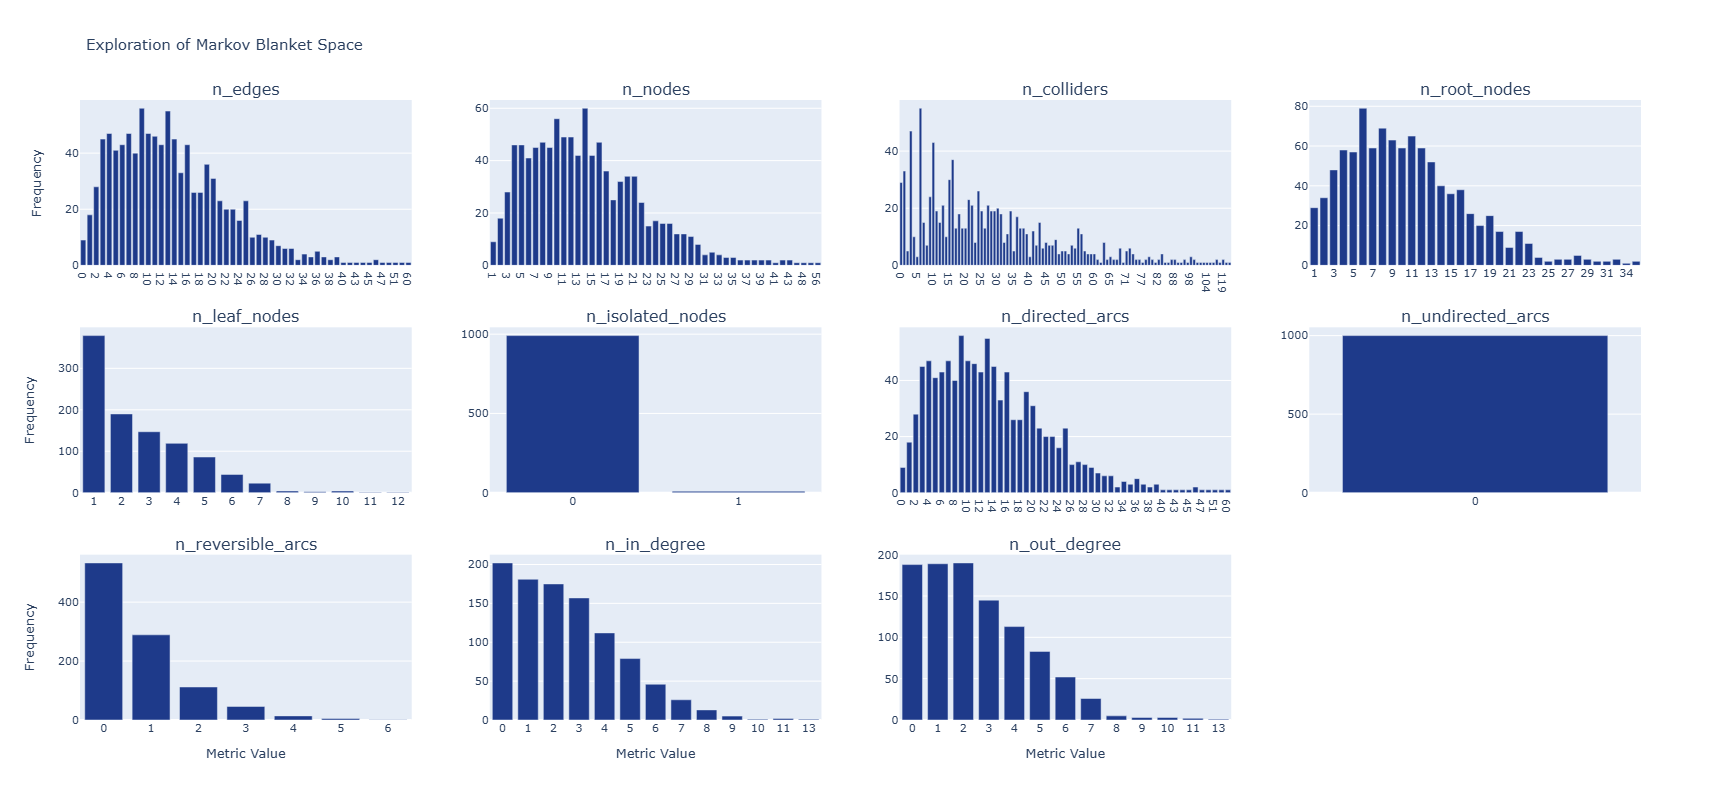

In [104]:
analyse_mb(dag)

### Conclusions

In this analysis, we explored a synthetic DAG with 1,000 nodes and examined both global and local structural properties using the `bnm` package. By focusing on Markov blankets, we were able to extract meaningful insights from a potentially overwhelming network structure.

We began by visualizing the Markov blanket of a specific node of interest (`X_32`) and followed the causal pathway upstream to include related nodes like `X_978` and `X_540`. This approach allowed us to isolate actionable regions within the network, demonstrating how Markov blanket analysis supports intervention planning.

Descriptive metrics provided a comprehensive overview of the network’s structure. For instance, the network contains 2,497 edges and 4,100 colliders, indicating a rich set of potential causal relationships. Isolated nodes were identified and confirmed via visualization, while Markov blankets were ranked by complexity using the `n_edges` metric. The most complex local structure contained 60 edges, and its visualization helped reveal the intricacies of information flow in the system.

Through the `analyse_mb` function, we further examined the distribution of key properties—such as the number of edges, nodes, and colliders—across all Markov blankets. Most blankets included fewer than 30 edges and 30 nodes, with the most common number of colliders being 6. These insights help characterize the network’s local topologies and inform where complexity and causal richness reside.

In summary, this analysis demonstrates the value of the `bnm` package in providing insights from medium to large DAGs.


### Other Cases: 
- [Compare Two DAGs](https://github.com/averinpa/bnm/blob/main/use%20cases/compare%20two%20DAGs.ipynb)
- [Compare Algorithms](https://github.com/averinpa/bnm/blob/main/use%20cases/compare%20algorithms.ipynb)